# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
from time import time
from tqdm import tqdm

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

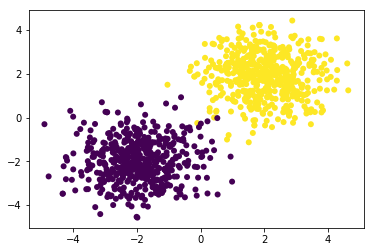

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [21]:
#net = Sequential()
#net.add(Linear(2, 2))
#net.add(LogSoftMax())



# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [20]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [18]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

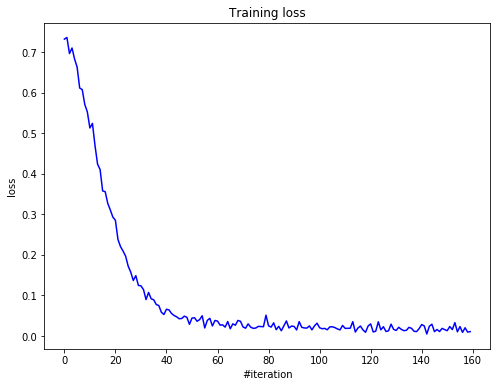

Current loss: 0.010836


In [22]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [23]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

One-hot encode the labels first.

In [24]:
def one_hot_encode(input, classes=10):
    one_hot_targets = np.eye(classes)[input]
    return one_hot_targets

In [25]:
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

### **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***


In [39]:

# Looping params
n_epoch = 25
batch_size = 500

# Learning params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-6}

In [40]:
def get_accuracy(y_pred, y_target):
    numbers = y_pred.argmax(axis=-1)
    numbers_target = y_target.argmax(axis=-1)
    return np.mean(numbers == numbers_target)

In [41]:
def train_epoch(net, criterion, X, y, batch_size, optimizer_config, optimizer_state, optimizer):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        net.zeroGradParameters()
        # Forward
        predictions = net.forward(x_batch)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        # Update weights
        optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        
    predictions = net.forward(X)
    return criterion.forward(predictions, y), get_accuracy(predictions, y)

In [42]:
def print_report(nets):
    df = pd.DataFrame(columns=['Network', 'Training loss', 'Validation loss', 'Training accuracy', 'Validation accuracy'])
    count = 0
    for net in nets:
        row = []
        row.append(net)
        row.append(round(nets[net]['train_loss'][-1], 3))
        row.append(round(nets[net]['test_loss'][-1], 3))
        row.append(round(nets[net]['train_acc'][-1], 3) * 100)
        row.append(round(nets[net]['test_acc'][-1], 3) * 100)
        df.loc[count] = row
        count+=1
    return df

In [43]:
np.random.seed(101)
# Define the net with ReLU
net_ReLU = Sequential()
net_ReLU.add(Linear(784, 100))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(100, 200))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(200, 10))
net_ReLU.add(LogSoftMax())

# Define the net with ELU
net_ELU = Sequential()
net_ELU.add(Linear(784, 100))
net_ELU.add(ELU())
net_ELU.add(Linear(100, 200))
net_ELU.add(ELU())
net_ELU.add(Linear(200, 10))
net_ELU.add(LogSoftMax())

# Define the net with LeakyReLU
net_LeakyReLU = Sequential()
net_LeakyReLU.add(Linear(784, 100))
net_LeakyReLU.add(LeakyReLU())
net_LeakyReLU.add(Linear(100, 200))
net_LeakyReLU.add(LeakyReLU())
net_LeakyReLU.add(Linear(200, 10))
net_LeakyReLU.add(LogSoftMax())

# Define the net with SoftPlus
net_SoftPlus = Sequential()
net_SoftPlus.add(Linear(784, 100))
net_SoftPlus.add(SoftPlus())
net_SoftPlus.add(Linear(100, 200))
net_SoftPlus.add(SoftPlus())
net_SoftPlus.add(Linear(200, 10))
net_SoftPlus.add(LogSoftMax())

nets = {'ReLU' : {'net' : net_ReLU,
                  'criterion' : ClassNLLCriterion(),
                  'opt_state' : {},
                  'train_loss': [],
                  'test_loss' : [],
                  'train_acc': [],
                  'test_acc' : [],
                  'time': 0,
                  'optimizer' : sgd_momentum},
        'ELU':   {'net' : net_ELU,
                  'criterion' : ClassNLLCriterion(),
                  'opt_state' : {},
                  'train_loss': [],
                  'test_loss' : [],
                  'train_acc': [],
                  'test_acc' : [],
                  'time' : 0,
                  'optimizer' : sgd_momentum},
        'LeakyReLU':  {'net' : net_LeakyReLU,
                       'criterion' : ClassNLLCriterion(),
                       'opt_state' : {},
                       'train_loss': [],
                       'test_loss' : [],
                       'train_acc': [],
                       'test_acc' : [],
                       'time' : 0,
                       'optimizer': sgd_momentum},
        'SoftPlus': {'net' : net_SoftPlus,
                     'criterion' : ClassNLLCriterion(),
                     'opt_state' : {},
                     'train_loss': [],
                     'test_loss' : [],
                     'train_acc': [],
                     'test_acc' : [],
                     'time' : 0,
                     'optimizer' : sgd_momentum}}

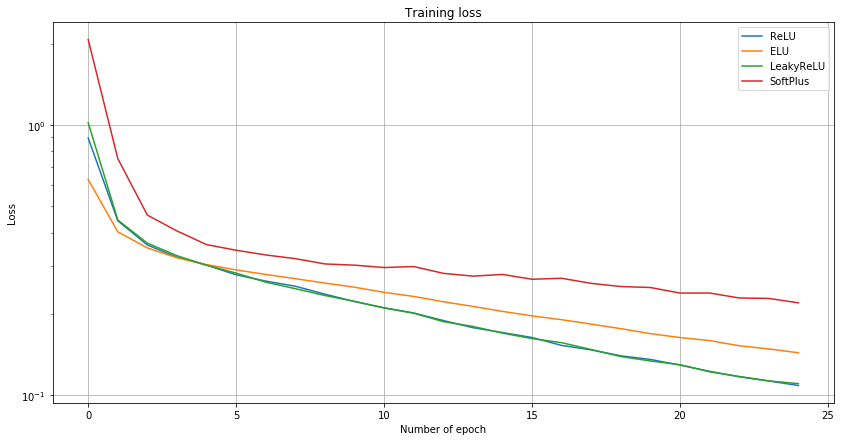

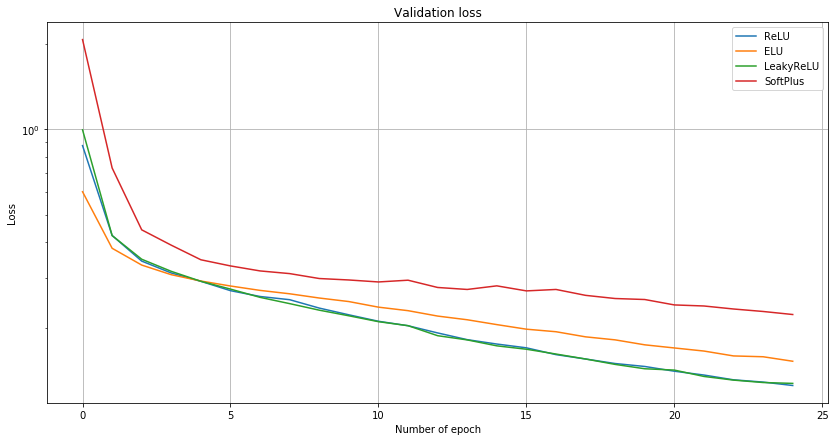

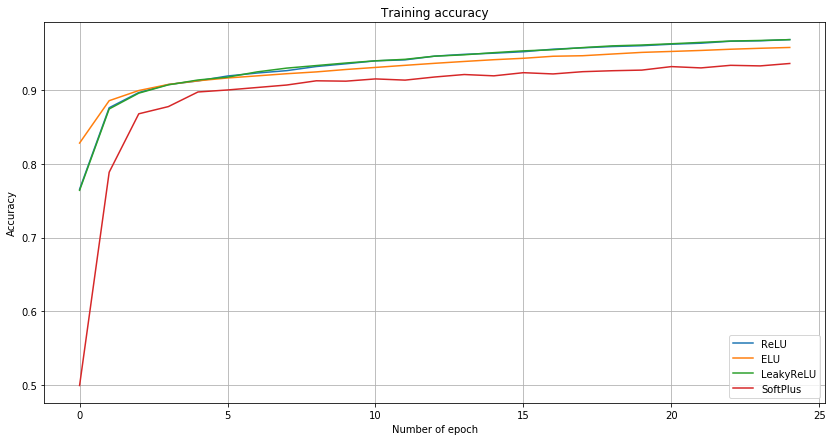

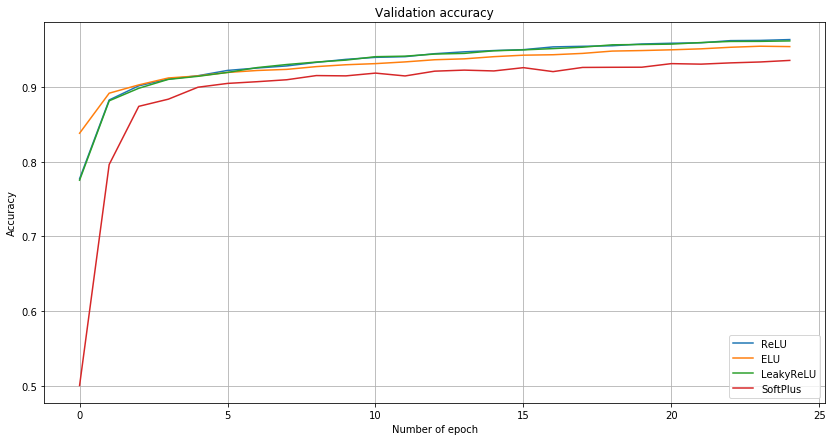

100%|██████████| 25/25 [04:00<00:00,  9.59s/it]

Time spent on training:
ReLU 32.8 s
ELU 58.21 s
LeakyReLU 37.17 s
SoftPlus 75.77 s


In [44]:
np.random.seed(101)
# Train the net
for i in tqdm(range(n_epoch)):
    for net in nets:
        time_start = time()
        loss, acc = train_epoch(nets[net]['net'], nets[net]['criterion'], X_train, y_train,
                                batch_size, optimizer_config, nets[net]['opt_state'],
                                nets[net]['optimizer'])
        time_end = time()
        nets[net]['time'] += (time_end - time_start)
        nets[net]['train_loss'].append(loss)
        nets[net]['train_acc'].append(acc)

        predictions_test = nets[net]['net'].forward(X_test)
        nets[net]['test_loss'].append(nets[net]['criterion'].forward(predictions_test, y_test))
        nets[net]['test_acc'].append(get_accuracy(predictions_test, y_test))

    display.clear_output(wait=True)
    # Plot training loss
    plt.figure(figsize=(14, 7))  
    plt.title("Training loss")
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['train_loss'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot validation loss
    plt.figure(figsize=(14, 7)) 
    plt.title("Validation loss")
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['test_loss'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot training accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Training accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['train_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot testing accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Validation accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['test_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
print("Time spent on training:")
for net in nets:
    print(net, round(nets[net]['time'], 2), "s")

In [45]:
print_report(nets)

,Network,Training loss,Validation loss,Training accuracy,Validation accuracy
0,ReLU,0.109,0.125,96.9,96.4
1,ELU,0.144,0.152,95.8,95.4
2,LeakyReLU,0.110,0.127,96.9,96.2
3,SoftPlus,0.220,0.223,93.6,93.6


As we can see on the plots and table ReLU gives the best result and has the lowest computational time compared to others. But one should to keep in mind that ReLU might fail training procedure after big number of epochs due to the effect called dead neurons. The best about ReLU is that it passes backward the maximum number of errors, in other words it suffers less from the vanishing gradient problem.
Of course, the problem of dead neurons could be solved using ELU or leaku ReLU, but in this case it shows that it does not benefit too much, but these alternatives have higher comp. time.
Meanwhile, SoftPlus has a way higher comp. time and does show better results. 

Section 6.3.3 of the Deep Learning book. (Goodfellow et. al, 2016):

_The use of softplus is generally discouraged._ <br>
_... one might expect it to have advantage over the rectifier due to being_ <br>
_differentiable everywhere or due to saturating less completely, but empirically it does not._

### **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

In [64]:
np.random.seed(101)
n_epoch = 30
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-6}
# Define the net with BN
net_BN = Sequential()
net_BN.add(Linear(784, 100))
net_BN.add(BatchNormalization(alpha=0.1))
net_BN.add(ChannelwiseScaling(100))
net_BN.add(ReLU())
net_BN.add(Linear(100, 200))
net_BN.add(ReLU())
net_BN.add(Linear(200, 10))
net_BN.add(LogSoftMax())

# Define the net without BN
net_woBN = Sequential()
net_woBN.add(Linear(784, 100))
net_woBN.add(ReLU())
net_woBN.add(Linear(100, 200))
net_woBN.add(ReLU())
net_woBN.add(Linear(200, 10))
net_woBN.add(LogSoftMax())

nets = {'w/ Batch Normalization' : {'net' : net_BN,
                                    'criterion' : ClassNLLCriterion(),
                                    'opt_state' : {},
                                    'train_loss': [],
                                    'test_loss' : [],
                                    'train_acc': [],
                                    'test_acc' : [],
                                    'time': 0,
                                    'optimizer' : sgd_momentum},
        'w/o Batch Normalization': {'net' : net_woBN,
                                    'criterion' : ClassNLLCriterion(),
                                    'opt_state' : {},
                                    'train_loss': [],
                                    'test_loss' : [],
                                    'train_acc': [],
                                    'test_acc' : [],
                                    'time' : 0,
                                    'optimizer' : sgd_momentum}}

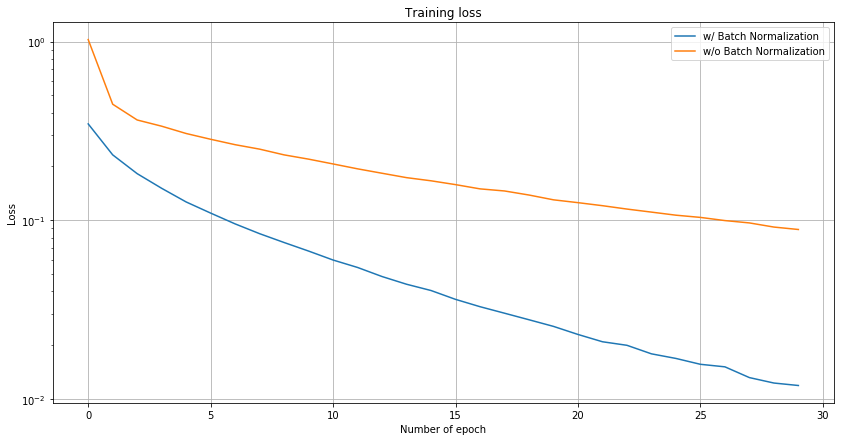

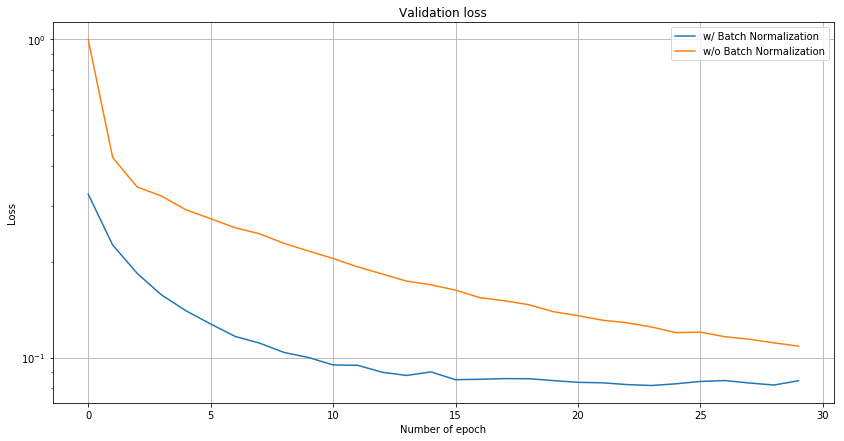

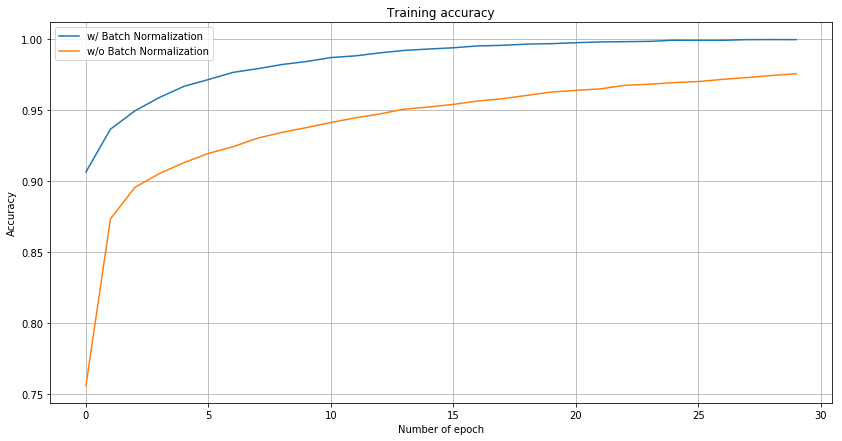

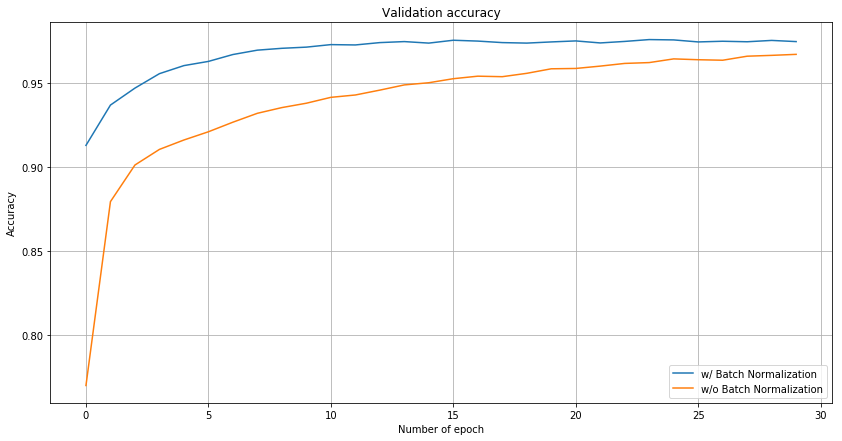


100%|██████████| 30/30 [01:54<00:00,  3.77s/it]


Time spent on training:
w/ Batch Normalization 44.06 s
w/o Batch Normalization 37.85 s


In [65]:
np.random.seed(101)
# Train the net
for i in tqdm(range(n_epoch)):
    for net in nets:
        nets[net]['net'].train()
        time_start = time()
        loss, acc = train_epoch(nets[net]['net'], nets[net]['criterion'], X_train, y_train,
                                batch_size, optimizer_config, nets[net]['opt_state'],
                                nets[net]['optimizer'])
        time_end = time()
        nets[net]['net'].evaluate()
        nets[net]['time'] += (time_end - time_start)
        nets[net]['train_loss'].append(loss)
        nets[net]['train_acc'].append(acc)

        predictions_test = nets[net]['net'].forward(X_test)
        nets[net]['test_loss'].append(nets[net]['criterion'].forward(predictions_test, y_test))
        nets[net]['test_acc'].append(get_accuracy(predictions_test, y_test))

    display.clear_output(wait=True)
    # Plot training loss
    plt.figure(figsize=(14, 7))  
    plt.title("Training loss")
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['train_loss'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot validation loss
    plt.figure(figsize=(14, 7)) 
    plt.title("Validation loss")
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['test_loss'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot training accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Training accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['train_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot testing accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Validation accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['test_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
print("Time spent on training:")
for net in nets:
    print(net, round(nets[net]['time'], 2), "s")

In [66]:
print_report(nets)

,Network,Training loss,Validation loss,Training accuracy,Validation accuracy
0,w/ Batch Normalization,0.012,0.085,99.9,97.5
1,w/o Batch Normalization,0.089,0.109,97.5,96.7


Batch Normalization gives a way better results. Initially, it was widely accepted that BN decreases so-called internal covariate shift. Long story short, this term refers to the change in the distribution of layer inputs caused by updates and it is believed that BN is to reduce ICS and eradicate negative impact on training.
But recent study "How Does Batch Normalization Help Optimization?" Shibani et al showed that in fact BN makes the surface of the corresponding optimization problem substantially more smooth, thereby making network convergence faster.

### Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***

In [67]:
np.random.seed(101)
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9, 'beta1': 0.9, 'beta2': 0.99, 'epsilon': 10e-6}
# Define the net
net_SGB = Sequential()
net_SGB.add(Linear(784, 100))
net_SGB.add(ReLU())
net_SGB.add(Linear(100, 200))
net_SGB.add(ReLU())
net_SGB.add(Linear(200, 10))
net_SGB.add(LogSoftMax())

net_Adam = Sequential()
net_Adam.add(Linear(784, 100))
net_Adam.add(ReLU())
net_Adam.add(Linear(100, 200))
net_Adam.add(ReLU())
net_Adam.add(Linear(200, 10))
net_Adam.add(LogSoftMax())

nets = {'SGD Momentum' : {'net' : net_SGB,
                                    'criterion' : ClassNLLCriterion(),
                                    'opt_state' : {},
                                    'train_loss': [],
                                    'test_loss' : [],
                                    'train_acc': [],
                                    'test_acc' : [],
                                    'time': 0,
                                    'optimizer' : sgd_momentum},
        'Adam optimizer': {'net' : net_Adam,
                                    'criterion' : ClassNLLCriterion(),
                                    'opt_state' : {},
                                    'train_loss': [],
                                    'test_loss' : [],
                                    'train_acc': [],
                                    'test_acc' : [],
                                    'time' : 0,
                                    'optimizer' : adam_optimizer}}

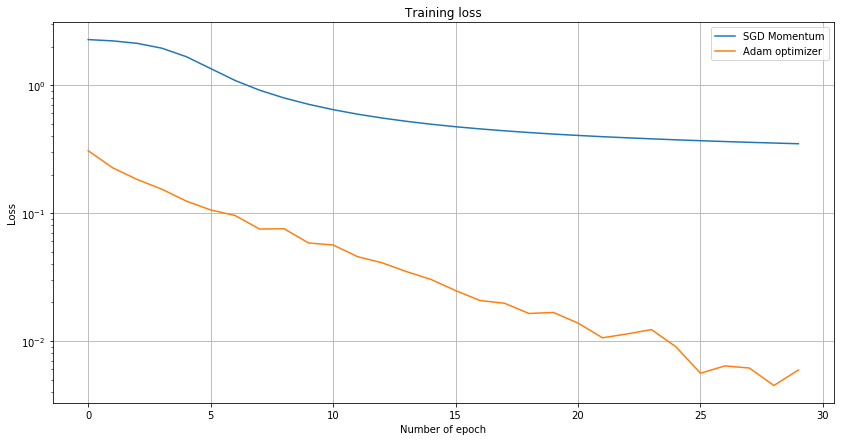

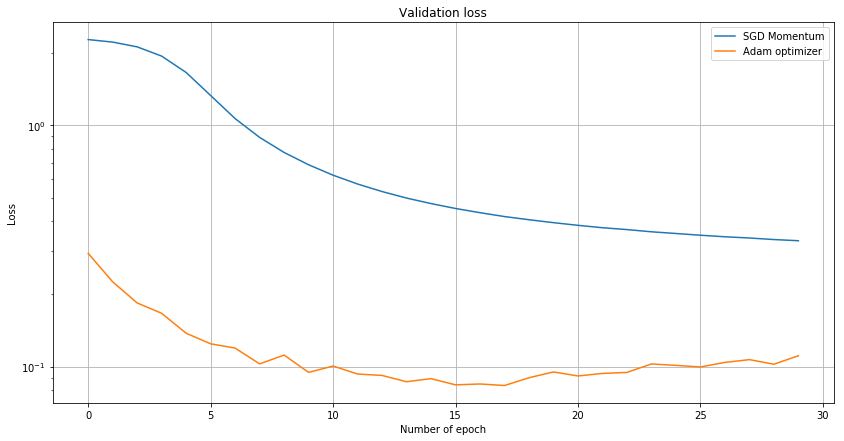

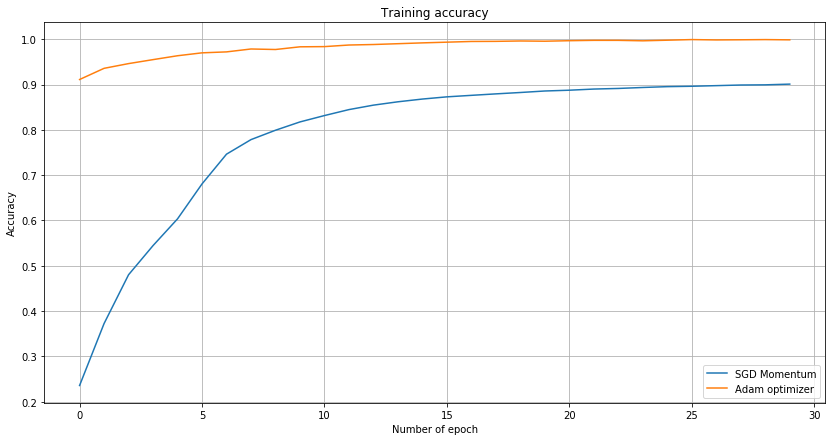

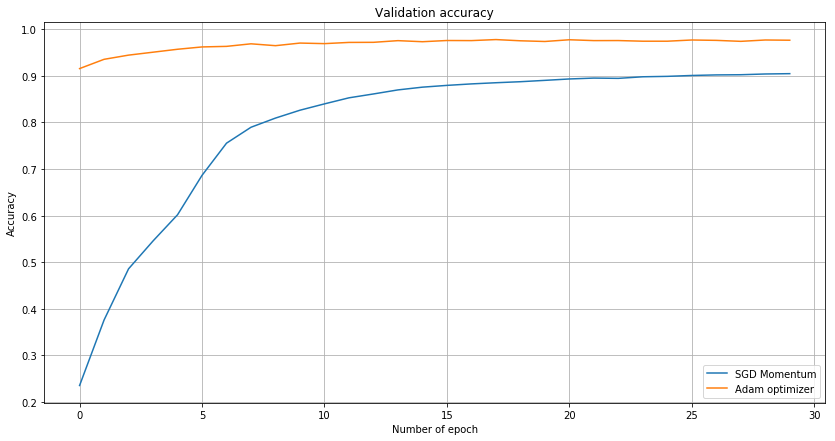


100%|██████████| 30/30 [01:51<00:00,  3.74s/it]


Time spent on training:
SGD Momentum 38.49 s
Adam optimizer 40.59 s


In [68]:
np.random.seed(101)
# Train the net
for i in tqdm(range(n_epoch)):
    for net in nets:
        nets[net]['net'].train()
        time_start = time()
        loss, acc = train_epoch(nets[net]['net'], nets[net]['criterion'], X_train, y_train,
                                batch_size, optimizer_config, nets[net]['opt_state'],
                                nets[net]['optimizer'])
        time_end = time()
        nets[net]['net'].evaluate()
        nets[net]['time'] += (time_end - time_start)
        nets[net]['train_loss'].append(loss)
        nets[net]['train_acc'].append(acc)

        predictions_test = nets[net]['net'].forward(X_test)
        nets[net]['test_loss'].append(nets[net]['criterion'].forward(predictions_test, y_test))
        nets[net]['test_acc'].append(get_accuracy(predictions_test, y_test))

    display.clear_output(wait=True)
    # Plot training loss
    plt.figure(figsize=(14, 7))  
    plt.title("Training loss")
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['train_loss'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot validation loss
    plt.figure(figsize=(14, 7)) 
    plt.title("Validation loss")
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['test_loss'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot training accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Training accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['train_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot testing accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Validation accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['test_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
print("Time spent on training:")
for net in nets:
    print(net, round(nets[net]['time'], 2), "s")

In [69]:
print_report(nets)

,Network,Training loss,Validation loss,Training accuracy,Validation accuracy
0,SGD Momentum,0.348,0.332,90.1,90.5
1,Adam optimizer,0.006,0.111,99.9,97.7


Compared to SGD Adam stores an exponentially decaying average of past squared gradients and keeps an exponentially decaying average of past gradients similar to momentum, which helps to achieve better results in this setup at the cost of slightly increased comp. time. In general, adaptive learning strategies diagonally scale the gradient based based on estimates of the curvature.

### Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between train and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***

In [71]:
np.random.seed(101)
batch_size = 500
n_epoch = 30
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
# Define the net
net_DROPOUT = Sequential()
net_DROPOUT.add(Linear(784, 400))
net_DROPOUT.add(Dropout(0.5))
net_DROPOUT.add(ReLU())
net_DROPOUT.add(Linear(400, 10))
net_DROPOUT.add(LogSoftMax())

net_woDROPOUT = Sequential()
net_woDROPOUT.add(Linear(784, 500))
net_woDROPOUT.add(ReLU())
net_woDROPOUT.add(Linear(500, 10))
net_woDROPOUT.add(LogSoftMax())

nets = {'w/ Dropout' : {'net' : net_DROPOUT,
                                    'criterion' : ClassNLLCriterion(),
                                    'opt_state' : {},
                                    'train_loss': [],
                                    'test_loss' : [],
                                    'train_acc': [],
                                    'test_acc' : [],
                                    'time': 0,
                                    'optimizer' : sgd_momentum},
        'w/o Dropout': {'net' : net_woDROPOUT,
                                    'criterion' : ClassNLLCriterion(),
                                    'opt_state' : {},
                                    'train_loss': [],
                                    'test_loss' : [],
                                    'train_acc': [],
                                    'test_acc' : [],
                                    'time' : 0,
                                    'optimizer' : sgd_momentum}}

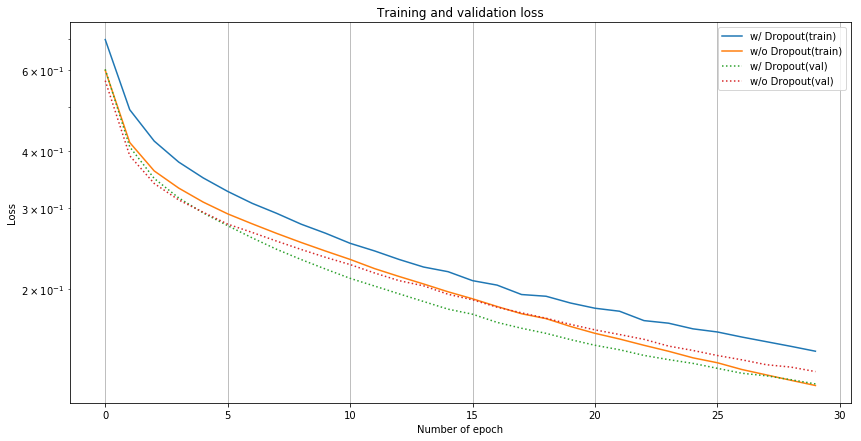

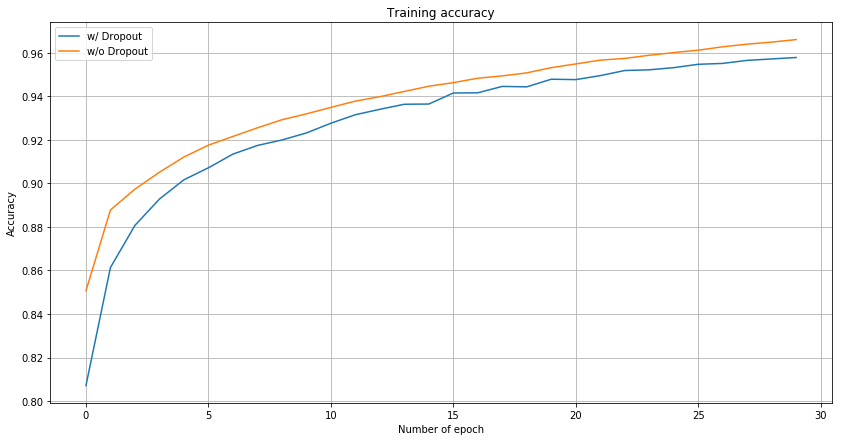

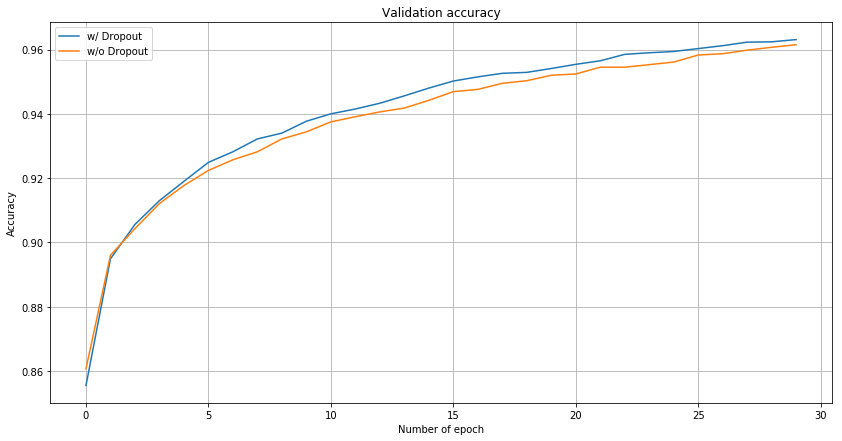


100%|██████████| 30/30 [04:25<00:00,  8.94s/it]


Time spent on training:
w/ Dropout 125.34 s
w/o Dropout 107.41 s


In [72]:
np.random.seed(101)
# Train the net
for i in tqdm(range(n_epoch)):
    for net in nets:
        nets[net]['net'].train()
        time_start = time()
        loss, acc = train_epoch(nets[net]['net'], nets[net]['criterion'], X_train, y_train,
                                batch_size, optimizer_config, nets[net]['opt_state'],
                                nets[net]['optimizer'])
        time_end = time()
        nets[net]['net'].evaluate()
        nets[net]['time'] += (time_end - time_start)
        nets[net]['train_loss'].append(loss)
        nets[net]['train_acc'].append(acc)

        predictions_test = nets[net]['net'].forward(X_test)
        nets[net]['test_loss'].append(nets[net]['criterion'].forward(predictions_test, y_test))
        nets[net]['test_acc'].append(get_accuracy(predictions_test, y_test))

    display.clear_output(wait=True)
    # Plot training loss
    plt.figure(figsize=(14, 7))  
    plt.title("Training and validation loss")
    plt.xlabel("Number of epoch")
    plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['train_loss'],label=net+"(train)")
    #plt.legend(loc='best')
    #plt.grid()
    #plt.show()
    
    # Plot validation loss
    #plt.figure(figsize=(14, 7)) 
    #plt.title("Validation loss")
    #plt.xlabel("Number of epoch")
    #plt.ylabel("Loss")
    for net in nets:
        plt.semilogy(nets[net]['test_loss'],label=net+"(val)",ls=':')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot training accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Training accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['train_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Plot testing accuracy
    plt.figure(figsize=(14, 7)) 
    plt.title("Validation accuracy")
    plt.xlabel("Number of epoch")
    plt.ylabel("Accuracy")
    for net in nets:
        plt.plot(nets[net]['test_acc'],label=net)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
print("Time spent on training:")
for net in nets:
    print(net, round(nets[net]['time'], 2), "s")

In [73]:
print_report(nets)

,Network,Training loss,Validation loss,Training accuracy,Validation accuracy
0,w/ Dropout,0.147,0.125,95.8,96.3
1,w/o Dropout,0.124,0.132,96.6,96.2


Usually, Dropout is used when network is prone to overfitting. By randomly dropping some layers the aim of Dropout is to reduce the overfitting on training phase. Actually, this can be easuly seen on the plots if one looks at the gap between validation and training loss. In the first setup w/o dropout (orange and dashed red lines) we can see that over the time they are getting too close (even merged at some point), this potentially might cause overfitting (also train loss getting too low). In the second setup with added dropout (blue and dashed green) we can see that the gap between train and loss are keeping distance, so dropout doesn't allow train loss to be so low. Also, dropout achieves slightly better accuracy on validation.

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

In [ ]:
#features : 'number of examples' * 'dimensionality'
f = #<YOUR CODE GOES HERE>

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))